## 시험 스크립트 2 : 스크립트1에서 저장된 weight와 훈련데이터의 일부를 이용해 축소모델 Shap Explainer 를 만들어 여기에 검증데이터 중에서 랜덤으로 뽑은 어느 한 샘플을 입력해 얻은 shap_value 로부터 악성종양 분류에의 기여도가 가장 큰 유전자 20개를 뽑은 다음, 이전 데이터셋에서 이 20개를 제외한 새로운 데이터셋을 만드는데, 이 과정을 10번 반복해서 10개의 데이터셋을 STAD_Dataset3_minus_20_exam_i.h5 로 저장

## 1. Loading helper modules & functions

In [1]:
%load_ext autoreload
%autoreload 2
import torch as T
import torch.nn as nn
import pandas as pd
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
import random
import shap
device = T.device("cuda" if T.cuda.is_available() else "cpu")
print("Pytorch version:", T.__version__, "CUDA version:", T.version.cuda, "cuDNN version:", T.backends.cudnn.version())
print("device:", device, T.cuda.get_device_name(0))

Pytorch version: 1.12.1 CUDA version: 11.3 cuDNN version: 8302
device: cuda NVIDIA RTX A6000


## 2. Implementing backbone of Transformer-based Classifier

In [2]:
# feature 개수 확인 및 설정
hf = h5py.File('STAD_Dataset3_ALL_exam.h5', 'r')
X_DATA = np.array(hf.get('X'))
Y_DATA = np.array(hf.get('Y'))
print('X_DATA.shape :', X_DATA.shape, ', X_DATA.dtype :', X_DATA.dtype)
print('Y_DATA.shape :', Y_DATA.shape, '     , Y_DATA.dtype :', Y_DATA.dtype)
hf.close()

n_feature = X_DATA.shape[1]
print("\nThe number of feature :", n_feature)

X_DATA.shape : (407, 1501) , X_DATA.dtype : float64
Y_DATA.shape : (407,)      , Y_DATA.dtype : int8

The number of feature : 1501


In [3]:
class STAD_Dataset(T.utils.data.Dataset):
    def __init__(self, src_file):
        hf = h5py.File(src_file, 'r')
        if 'X_Train' in hf.keys() :
            # X = np.array(hf.get('X_Train')).astype('int64')
            X = np.array(hf.get('X_Train'))
            Y = np.array(hf.get('Y_Train')).astype('int8')
        else :
            # X = np.array(hf.get('X_Test')).astype('int64')
            X = np.array(hf.get('X_Test'))
            Y = np.array(hf.get('Y_Test')).astype('int8')
        hf.close()

        # self.x_data = T.tensor(X, dtype=T.int64).to(device)
        self.x_data = T.tensor(X, dtype=T.float32).to(device)
        self.y_data = T.tensor(Y, dtype=T.int64).to(device)  

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx] 
        return x, y  

In [4]:
class PositionalEncoding(T.nn.Module):  
    def __init__(self, d_model: int, dropout: float=0.1, max_len: int=n_feature):
        super(PositionalEncoding, self).__init__()  
        self.dropout = T.nn.Dropout(p=dropout)
        pe = T.zeros(max_len, d_model)  
        position = T.arange(0, max_len, dtype=T.float32).unsqueeze(1)
        div_term = T.exp(T.arange(0, d_model, 2).float() * (-np.log(10_000.0) / d_model))
        pe[:, 0::2] = T.sin(position * div_term)
        pe[:, 1::2] = T.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)  # 이게 없으면 나중에 forward 에서 pe값을 못 찾아 에러남

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [5]:
# E = number of cases that all features can express in integer (feature=token) 
# D = #Embedding Dimension ; I = #input features ; F = #fc1 layer hidden nodes ; drop = dropout rate
E = 320 ; D = 8 ; I = n_feature ; F = 8 ; drop = 0.1
class Transformer_Classifier(T.nn.Module):  # 1501 -> 12008 -> Transformer -> FC -> 4
    def __init__(self):
        super(Transformer_Classifier, self).__init__() 
        # numeric pseudo-embedding, dim=D
        # self.embed = Special_Embedding_Layer(I, I*D)  # I input features, each goes to D 
        self.embed = T.nn.Embedding(E, D)  # I input features, each goes to D
        self.pos_enc = PositionalEncoding(D, dropout=drop)  # positional embedding
        self.enc_layer = T.nn.TransformerEncoderLayer(d_model=D, nhead=4, dim_feedforward=D, 
                         dropout=drop, batch_first=True)  # d_model should be divisible by nhead
        self.trans_enc = T.nn.TransformerEncoder(self.enc_layer, num_layers=3)  # default 6 layers 
        # STAD Dataset has I input features per each sample
        self.dropout = nn.Dropout(drop)
        # self.fc1 = T.nn.Linear(D*I, F)  # F hidden nodes
        # self.fc2 = T.nn.Linear(F, 4)    # 4 classes
        self.fc3 = T.nn.Linear(D*I, 4)    # 4 classes (GX, G1, G2, G3)

    def forward(self, x):
        # x = I input features, fixed length
        z = self.embed(x.int())  # I inputs to I*D embeds
        z = z.reshape(-1, I, D) 
        z = self.pos_enc(z) 
        z = self.trans_enc(z) 
        z = z.reshape(-1, D*I)  # torch.Size([batch_size, D*I])
        # z = self.dropout(z)
        # z = self.fc1(z)
        # z = T.tanh(z)
        z = self.dropout(z)
        z = self.fc3(z)
        z = T.log_softmax(z, dim=1)  # later followed by NLL Loss()
        return z

### 3-0. Data Random Splitting 

In [6]:
# 1. Train : Test 를 레이블 비율을 균등하게 유지하면서 8 : 2로 랜덤하게 나눔
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_DATA, Y_DATA, test_size=0.2, stratify=Y_DATA)

# 2. Train 데이터 파일로 저장
hf = h5py.File('STAD_Dataset3_Train_exam.h5', 'w')
hf.create_dataset('X_Train', data=X_Train)
hf.create_dataset('Y_Train', data=Y_Train)
hf.close()
# 3. Test 데이터 파일로 저장 
hf = h5py.File('STAD_Dataset3_Test_exam.h5', 'w')
hf.create_dataset('X_Test', data=X_Test)
hf.create_dataset('Y_Test', data=Y_Test)
hf.close()

print('X_Train.shape : ', X_Train.shape)
print('Y_Train.shape : ', Y_Train.shape)
print('X_Test.shape  : ', X_Test.shape)
print('Y_Test.shape  : ', Y_Test.shape)
"Y_Test", Y_Test # 매번 랜덤으로 들어가는 지 확인

X_Train.shape :  (325, 1501)
Y_Train.shape :  (325,)
X_Test.shape  :  (82, 1501)
Y_Test.shape  :  (82,)


('Y_Test',
 array([3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 2, 1, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2,
        2, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3,
        3, 3, 3, 3, 2, 2, 0, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 3, 3, 3,
        3, 2, 3, 2, 0, 2, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3], dtype=int8))

### 3-1. Lodaing Dataset

In [7]:
# 0. setup
print("Making tensor dataset of STAD samples on device", device, T.cuda.get_device_name(0))
np.random.seed(1)  
T.manual_seed(1)  

# 1. create Dataset
train_file = "./STAD_Dataset3_Train_exam.h5"
train_ds = STAD_Dataset(train_file)
print(" ", len(train_ds), "training dataset created from an h5 file")

test_file = "./STAD_Dataset3_Test_exam.h5"
test_ds = STAD_Dataset(test_file)
print(" ", len(test_ds), "test dataset created from an h5 file")

print("\n   ", train_ds[324][0], train_ds[324][0].shape) 
print("   ", train_ds[324][1], train_ds[324][1].shape)

Making tensor dataset of STAD samples on device cuda NVIDIA RTX A6000
  325 training dataset created from an h5 file
  82 test dataset created from an h5 file

    tensor([202.7856, 197.2798, 180.4162,  ...,   0.0000, 155.6477,  87.9757],
       device='cuda:0') torch.Size([1501])
    tensor(2, device='cuda:0') torch.Size([])


## 7. Analizing the degree of contribution of each feature using SHAP

#### 7-1. 트랜스포머 인코더 feature 번호가 어떤 유전자ID였는지 참조할 리스트 만들고 각 유전자ID에 해당하는 gene symbol 리스트 만들기

In [8]:
df_All = pd.read_pickle('xy_STAD-related-only3_exam.pkl')
df_X = df_All.drop(labels=['neoplasm_histologic_grade','submitter_id.samples'], axis=1)
STAD_related_geneID_list = df_X.columns

df = pd.read_excel('GASCplusPHGDH_1554.xlsx')

STAD_related_gene_symbol_list = []
for gene_ID in STAD_related_geneID_list:
    for i, E_ID in enumerate(df['Ensembl ID']):
        if gene_ID == E_ID:
            STAD_related_gene_symbol_list.append(df['Gene Symbol'][i])
print("Length of the gene symbol list :", len(STAD_related_gene_symbol_list))

Length of the gene symbol list : 1501


### 7-2. Plotting shapley values using Gradient Explainer with transformer

In [9]:
# 훈련했던 모델 불러오기
model = Transformer_Classifier().to(device)
model.load_state_dict(T.load('./exam.pt'))

<All keys matched successfully>

In [10]:
# 복잡한 트랜스포머 모델을 설명하기 위한 작은 축소 모델 만들기 
ge = shap.GradientExplainer((model, model.trans_enc), train_ds.x_data[:275])

In [11]:
# 레이블이 G3인 샘플 인덱스 전부를 test_ds 에서 추출하고 
G3_index_list_from_testset = []
G3_index_list_10 = []
for i in range(len(test_ds)):
    if test_ds[i][1] == 3:
        G3_index_list_from_testset.append(i)

# 전체 48개 인덱스 중 10개를 랜덤으로 뽑기
G3_index_list_10 = random.sample(G3_index_list_from_testset, 10)
"G3_index_list_10", G3_index_list_10

('G3_index_list_10', [52, 37, 26, 77, 41, 42, 45, 79, 64, 16])

In [12]:
# 축소모델로 shapley value 구하기
G_shap_values = ge.shap_values(test_ds.x_data[G3_index_list_10])
len(G_shap_values), G_shap_values[3].shape, G_shap_values[3][9].shape, G_shap_values[3][9].T.shape

(4, (10, 1501, 8), (1501, 8), (8, 1501))

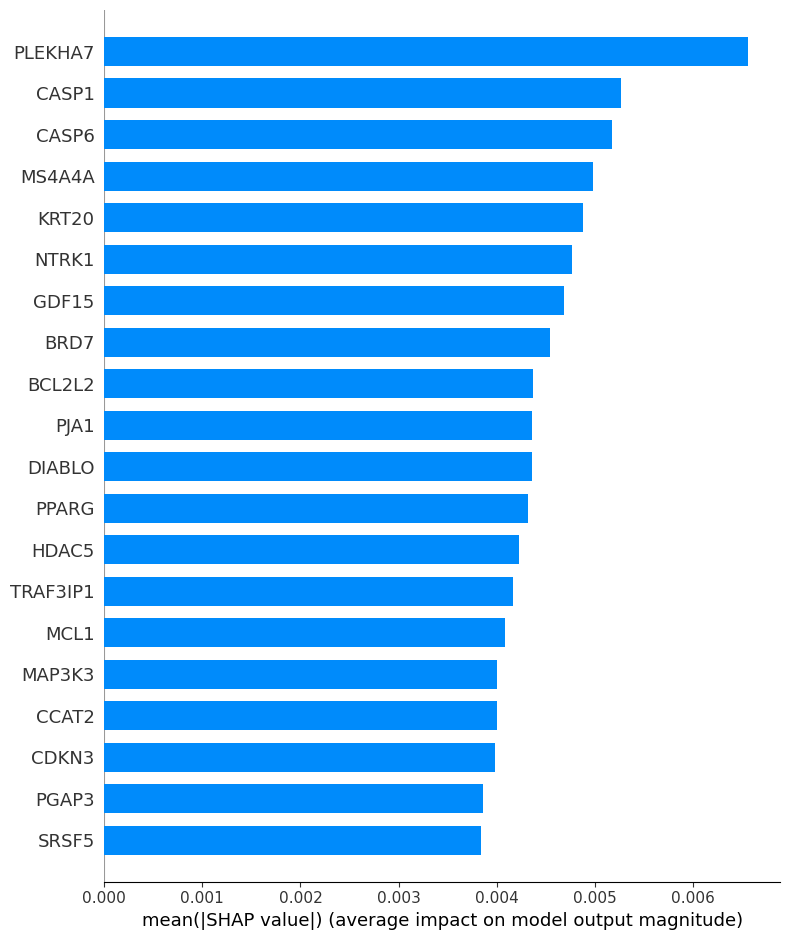

xy_STAD-related-only3_exam_features_removed_0.pkl saved


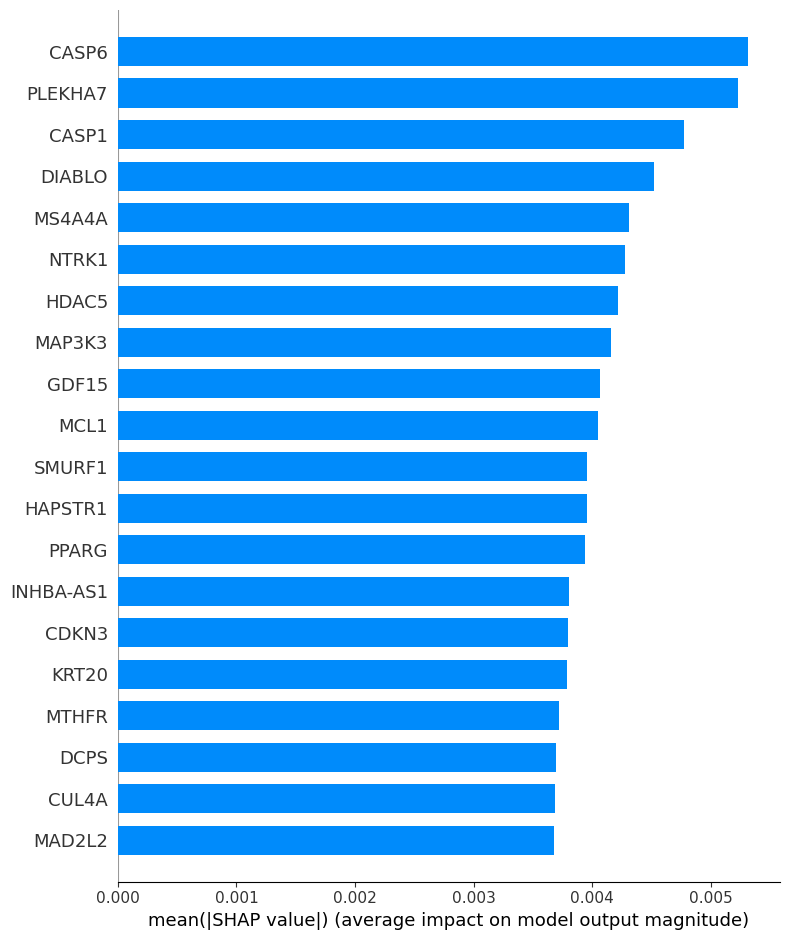

xy_STAD-related-only3_exam_features_removed_1.pkl saved


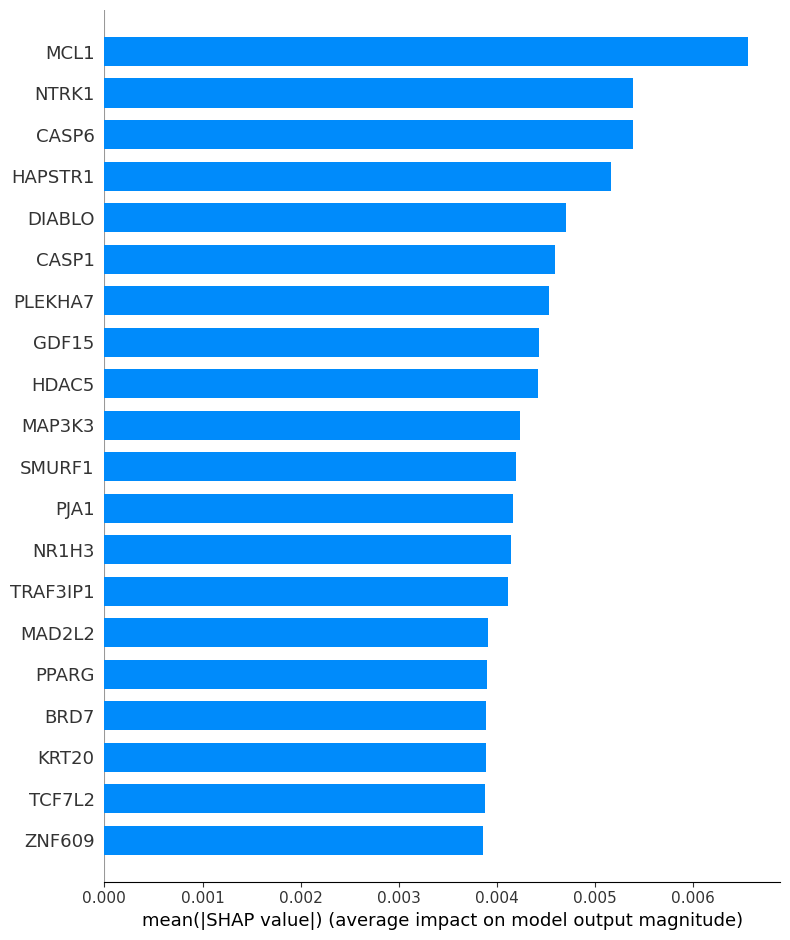

xy_STAD-related-only3_exam_features_removed_2.pkl saved


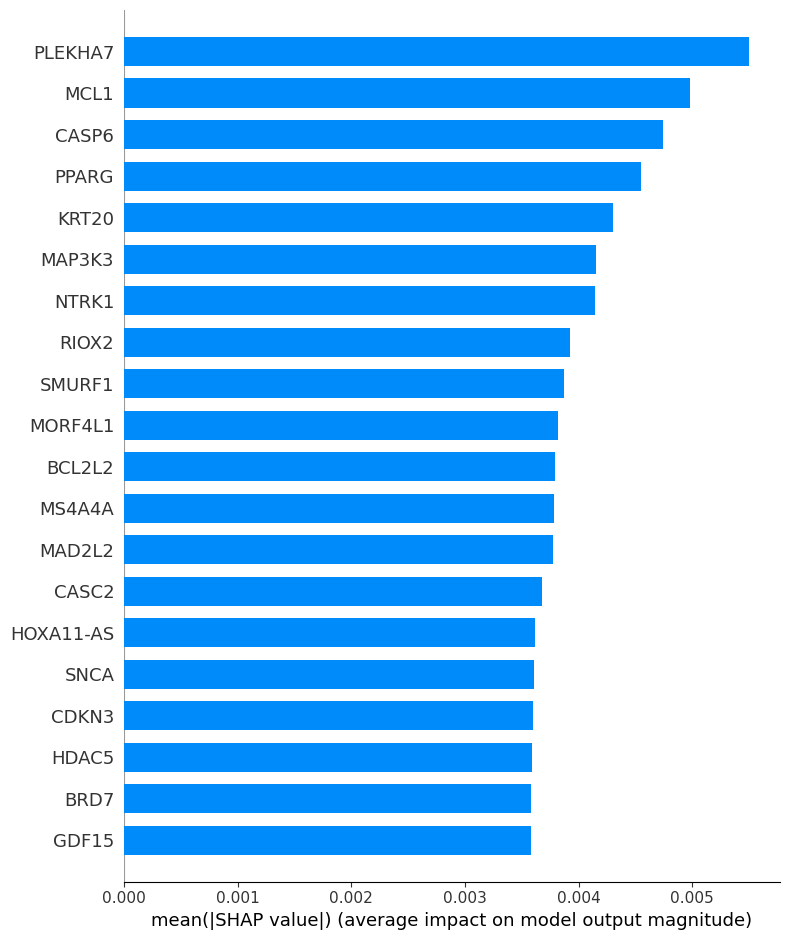

xy_STAD-related-only3_exam_features_removed_3.pkl saved


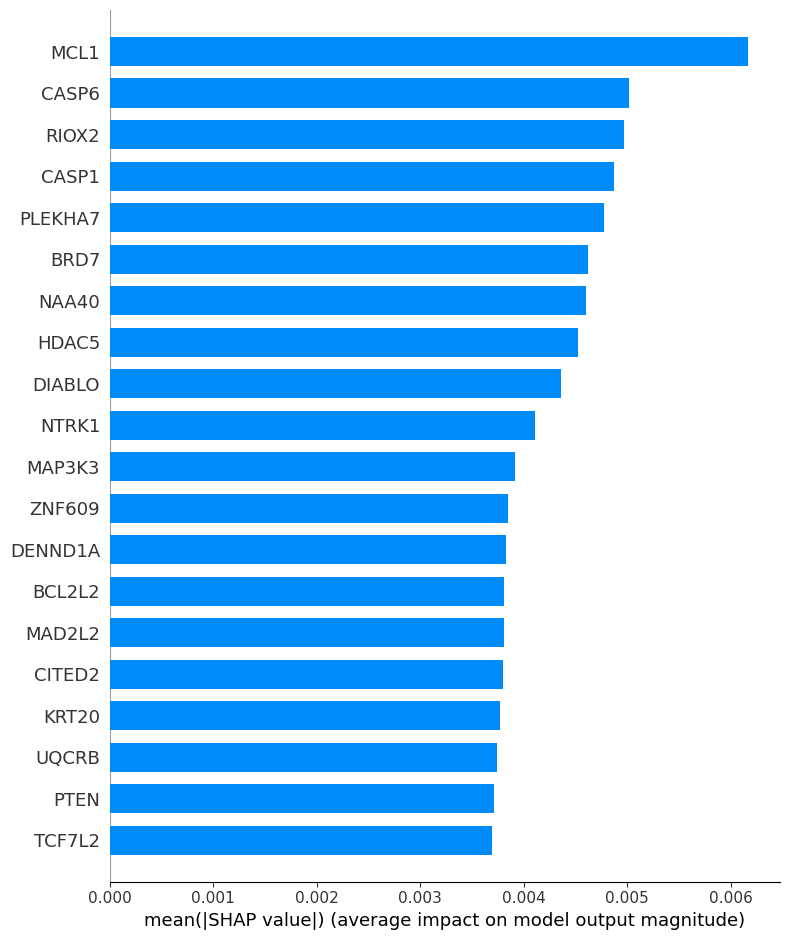

xy_STAD-related-only3_exam_features_removed_4.pkl saved


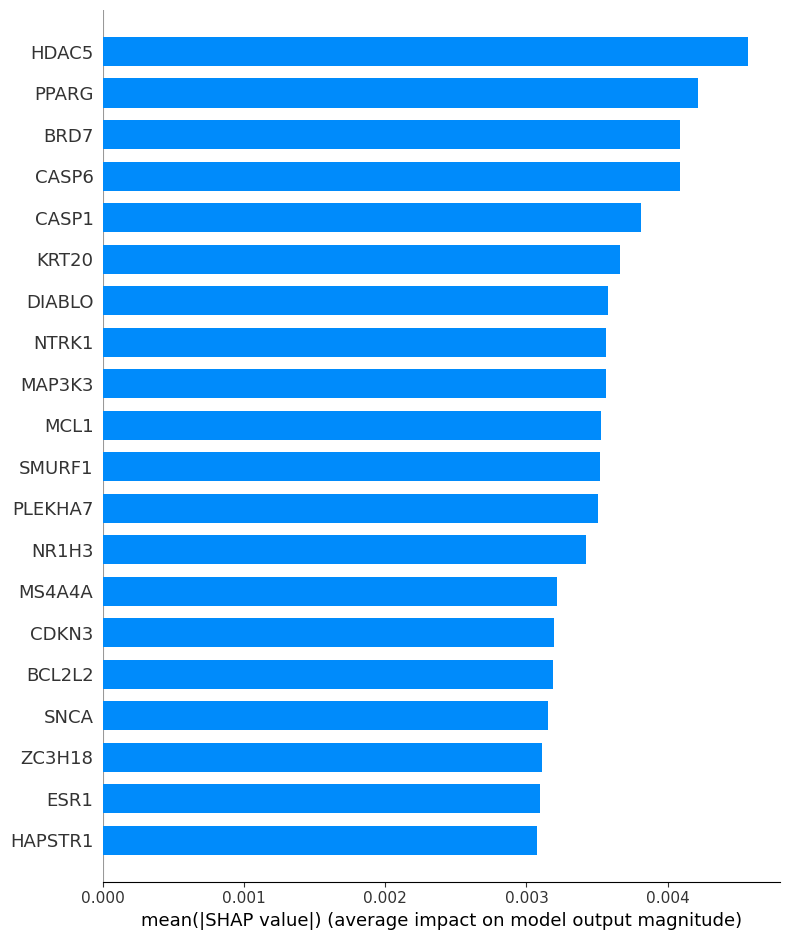

xy_STAD-related-only3_exam_features_removed_5.pkl saved


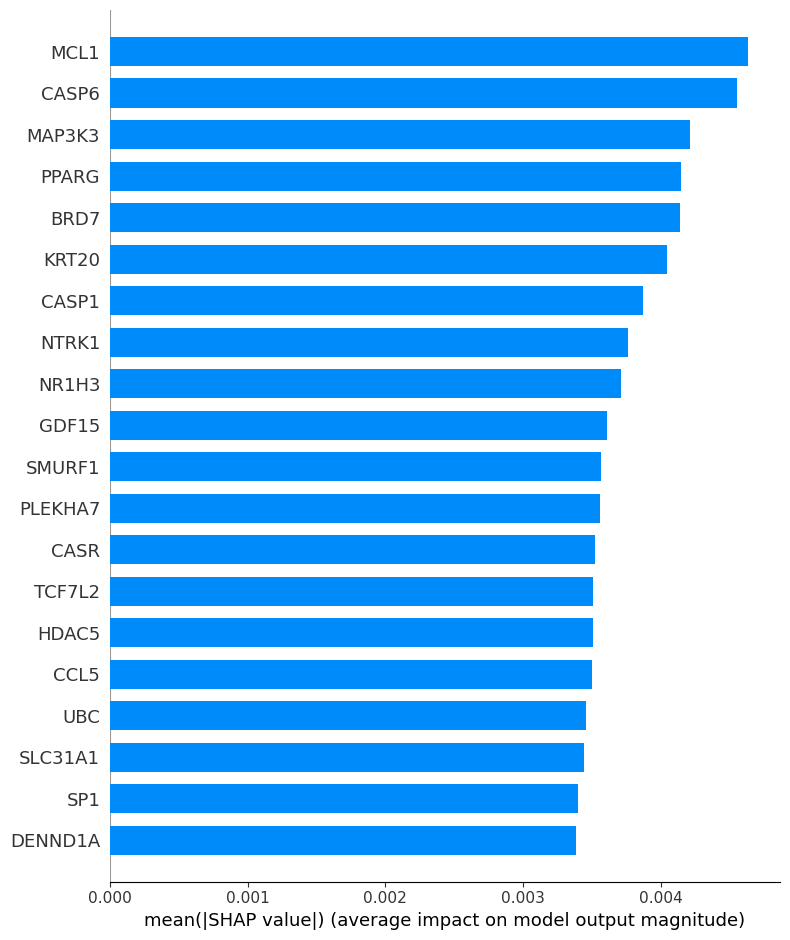

xy_STAD-related-only3_exam_features_removed_6.pkl saved


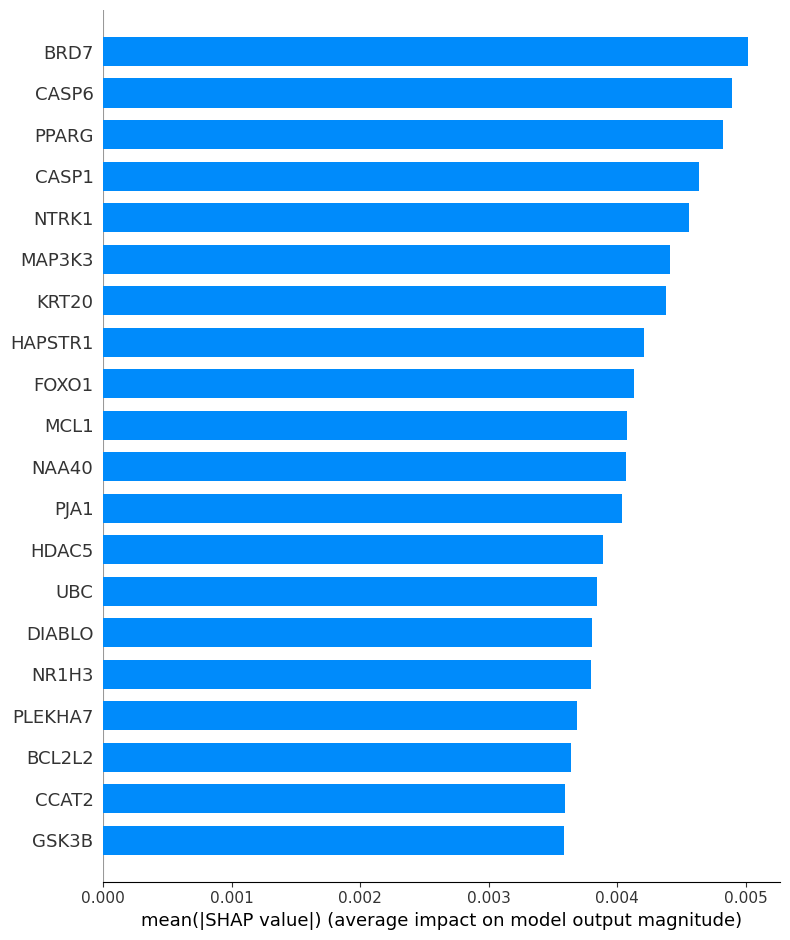

xy_STAD-related-only3_exam_features_removed_7.pkl saved


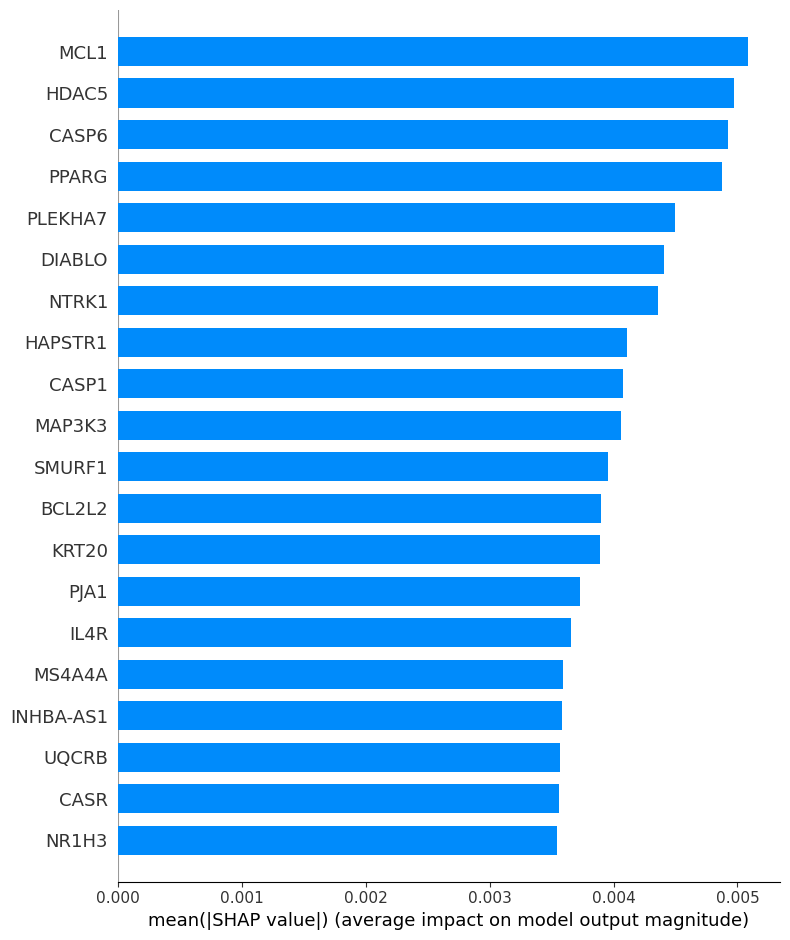

xy_STAD-related-only3_exam_features_removed_8.pkl saved


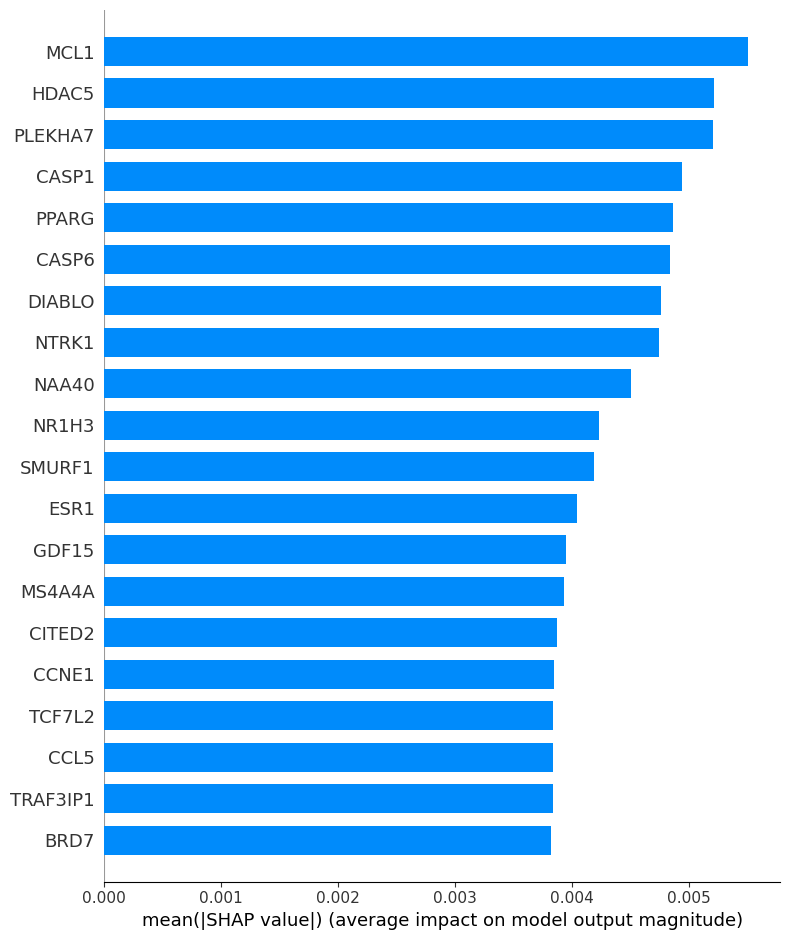

xy_STAD-related-only3_exam_features_removed_9.pkl saved


In [13]:
for i in range(10):
    # Shapley value 로 각 feature 들의 (모델추론결과(분류)에의) 기여도(영향력) 그래프 그리기
    shap.summary_plot(G_shap_values[3][i].T, plot_type='bar', features=STAD_related_gene_symbol_list)

    ##### 7-3. 악성종양 분류에의 기여도가 가장 큰 20개의 유전자를 뺀 데이터 파일 만들기 

    # 위 그래프 상황 데이터프레임으로 재현
    shap_df = pd.DataFrame(data=G_shap_values[3][i])
    symbol_df = pd.DataFrame(data=STAD_related_gene_symbol_list)
    symbol_shap_df = pd.concat([symbol_df, shap_df], axis=1)
    mean_df = pd.DataFrame(np.mean(np.abs(G_shap_values[3][i]), axis=1))
    symbol_shap_mean_df = pd.concat([symbol_shap_df, mean_df], axis=1)
    symbol_shap_mean_df.columns=['G_symbol','head1','head2','head3','head4','head5','head6','head7','head8','abs_mean']
    symbol_shap_mean_df_sorted = symbol_shap_mean_df.sort_values(by=['abs_mean'], ascending=[False])

    # 상위 20개의 Gene symbol 에 해당하는 Ensenbl ID를 GASCplusPHGDH_1554 df 에서 찾아 리스트로 만들기  
    ENSG_IDs_to_remove = []
    for G in symbol_shap_mean_df_sorted.iloc[0:20]['G_symbol']:
        ENSG_IDs_to_remove.append(df[df['Gene Symbol']==G]['Ensembl ID'].to_string()[-15:])

    # 전체 데이터프레임으로부터 위 리스트의 요소가 컬럼이름인 데이터를 제거한 데이터프레임 만들기
    df_All_features_removed = df_All.drop(labels=ENSG_IDs_to_remove, axis=1)

    # 최종 데이터프레임을 pickle 파일로 저장
    df_All_features_removed.to_pickle(f'./xy_STAD-related-only3_exam_features_removed_{i}.pkl')
    print(f'xy_STAD-related-only3_exam_features_removed_{i}.pkl saved')

# Data Preprocessing for multi-class Classification in the domain of TCGA-STAD (The Cancer Genome Atlas Stomach Adenocarcinoma)

## 1. Making the final numpy dataset of XY values for inserting into model

### 1-1. 파일 초기화 셀

In [14]:
# # xy_STAD-related-only3_exam_features_removed.pkl 파일을 처음으로 복구하는 코드 (만일 대비)
# df_init = pd.read_pickle('xy_STAD-related-only3_exam.pkl')
# df_init.to_pickle('./xy_STAD-related-only3_exam_features_removed.pkl')
# # 복구 확인
# df_init_check = pd.read_pickle('xy_STAD-related-only3_exam_features_removed.pkl')
# df_init_check.shape

In [15]:
for i in range(10):
    ### 1-2. Extracting dataset X & Y
    dfs2 = pd.read_pickle(f'xy_STAD-related-only3_exam_features_removed_{i}.pkl')
    df_X = dfs2.drop(labels=['neoplasm_histologic_grade','submitter_id.samples'], axis=1)
    df_Y = dfs2[['neoplasm_histologic_grade']]
    # NLL Loss 계산을 위해 label 차원은 2차원 행렬이 아닌 평범한 1차원 벡터가 되게 바꿈 
    df_Y = dfs2['neoplasm_histologic_grade']

    ### 1-3. Converting data for deep learning model 
    # X 데이터 : pandas dataframe 형식에서 numpy array 형식으로 변환
    X = df_X.to_numpy(dtype='float64')
    X.shape, X[0].dtype
    # Y 데이터 : 문자에서 정수로 변환 G1->1, G2->2, G3->3, GX->0
    Y = df_Y.replace({'G1':1, 'G2':2, 'G3':3, 'GX':0}).to_numpy(dtype='int8')
    Y.shape, Y[0].dtype

    ### 1-4. Min-Max Normalization for richer transformer embedding
    def MinMax(X):
        X_norm = (X-np.min(X)) / (np.max(X)-np.min(X))
        return X_norm
    X_norm = MinMax(X) * 319

    ### 1-5. Save dataset
    # 전체 X, Y 데이터셋 저장
    hf = h5py.File(f'STAD_Dataset3_minus_20_exam_{i}.h5', 'w')
    hf.create_dataset('X', data=X_norm)
    hf.create_dataset('Y', data=Y)
    hf.close()

    ### 1-6. Dataset Validation Check
    hf = h5py.File(f'STAD_Dataset3_minus_20_exam_{i}.h5', 'r')
    # hf.keys()
    X = np.array(hf.get('X'))
    Y = np.array(hf.get('Y'))
    hf.close()

    print(f'STAD_Dataset3_minus_20_exam_{i}.h5 saved')
    
print('\nX.shape :', X.shape, X[0].dtype)
print('Y.shape :', Y.shape, Y[0].dtype)

STAD_Dataset3_minus_20_exam_0.h5 saved
STAD_Dataset3_minus_20_exam_1.h5 saved
STAD_Dataset3_minus_20_exam_2.h5 saved
STAD_Dataset3_minus_20_exam_3.h5 saved
STAD_Dataset3_minus_20_exam_4.h5 saved
STAD_Dataset3_minus_20_exam_5.h5 saved
STAD_Dataset3_minus_20_exam_6.h5 saved
STAD_Dataset3_minus_20_exam_7.h5 saved
STAD_Dataset3_minus_20_exam_8.h5 saved
STAD_Dataset3_minus_20_exam_9.h5 saved

X.shape : (407, 1481) float64
Y.shape : (407,) int8
